In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

# A/B testing to improve Conversion Rates

You work for Company K. Company K is a video streaming service that is selling subscriptions. After running a few analyses, you suggest to the Product Team that placing more prominent upsells on the landing page may result in higher conversion rates (visitors signing up for the subscription). The Product Team took your suggestion with excitement and the engineering team went ahead and implemented the experiment right away. 

The experiment ran for the month of February 2020. You prepared a few datasets beforehand that will help you in analyzing the success of the A/B test.
The A/B test had two experiment groups, A & B, in which visitors assigned to A were in the control group and visitors assigned to B received the new variant with the new upsells. You suggest to assign approximately 7% of the daily visitors to the experiment, applying a 50/50 split among the two variants.

You have the following datasets:

1. `first_pageviews`: This is a summary of all the unsubscribed users and the timestamp of their first pageview. Users get assigned according to their cookies, which is how we make sure that a user may not be assigned to two different groups when they reach our landing page. Since visitors haven't signed up at this point, they don't have a `user_id`, instead, we assign them a random but unique `anonymous_id`. If visitors get assigned to an experiment, you should see a non-null value in the `exp_id` column. Your experiment has the ids **101** for control and **102** for the variant.
2. `subscribers`: This table shows you which users have subscribed at what point in time. To subscribe, you need to be a registered user, which is how you can uniquely identify each subscriber. Since we only sell yearly subscriptions, users cannot have more than 1 subscription within 365 days. 
3. `users`: This table is useful to link the first pageview of unsubscribed visitors to our subscribers. It keeps track of the `anonymous_id` we assigned to them and maps to the `user_id` we assigned after they sign up

Immediately after the end of the experiment, the Product Manager approaches you overly excited and wants you to analyze the success of the experiment.

You can find the datasets in the `data/2020-03-01` folder.

In [3]:
# load the datasets
first_pageviews = pd.read_csv('data/2020-03-01/first_pageviews.csv')
users = pd.read_csv('data/2020-03-01/users_mar01.csv')
subscriptions = pd.read_csv('data/2020-03-01/subscriptions_mar01.csv')

## Inspect the data

In [4]:
# show the first 5 lines of each dataset
first_pageviews.head()

,date_id,anonymous_id,exp_id
0,2020-01-16,4d005f94-e06f-493c-b569-9efb5ce4d203,NaN
1,2020-01-16,948ad58a-f483-4007-aa56-280aa018427b,NaN
2,2020-01-16,31f4f2e4-4ae6-417b-8a6d-53b98a719145,NaN
3,2020-01-16,24747dc7-355a-44b0-95c6-0caa91cd4ae4,NaN
4,2020-01-16,0162c4f8-7bc2-4432-90b9-bfb61f5e57b3,NaN


In [5]:
users.head()

,anonymous_id,user_id
0,e575dd8c-f02c-4a1a-8a53-fef7ff2b9f95,b67781da-3a0f-48af-80d8-728d3ec31c66
1,a92532b2-0317-49bb-9f00-3d9b9ae71ea5,ce1764ca-91a2-4c2e-95fe-c415c5df7be5
2,9c39b4d4-d7da-49e2-bcd9-4abee3e211f6,b24712a4-40b7-4841-a9e9-f566d9ed48a9
3,858cc4cc-dcd2-4897-815b-500a2ee8c00e,d0e4f27e-11ab-470c-85db-4f7389ba63d4
4,96a9ad69-568e-40bd-9ff7-3e6b8e0d3f9a,91b679ad-38cc-4569-b5fc-8a98dc858b8d


In [6]:
subscriptions.head()

,user_id,created_at,client_app
0,b67781da-3a0f-48af-80d8-728d3ec31c66,2020-01-26 09:00:55.628471160,android
1,ce1764ca-91a2-4c2e-95fe-c415c5df7be5,2020-01-30 10:43:16.359589080,ios
2,b24712a4-40b7-4841-a9e9-f566d9ed48a9,2020-02-15 21:19:35.663792880,web
3,d0e4f27e-11ab-470c-85db-4f7389ba63d4,2020-02-13 04:45:52.198410780,ios
4,91b679ad-38cc-4569-b5fc-8a98dc858b8d,2020-02-10 13:24:29.670026400,android


In [7]:
# check the data types and set them properly for each dataset
first_pageviews.dtypes


date_id          object
anonymous_id     object
exp_id          float64
dtype: object

In [8]:
first_pageviews['date_id'] = pd.to_datetime(first_pageviews['date_id'], format = "%Y/%m/%d")


In [9]:
users.dtypes

anonymous_id    object
user_id         object
dtype: object

In [10]:
subscriptions.dtypes

user_id       object
created_at    object
client_app    object
dtype: object

In [11]:
subscriptions['created_at'] = pd.to_datetime(subscriptions['created_at'])
subscriptions.dtypes

user_id               object
created_at    datetime64[ns]
client_app            object
dtype: object

In [12]:
# plot first pageview per day to inspect if you can spot any outliers or anything suspicious

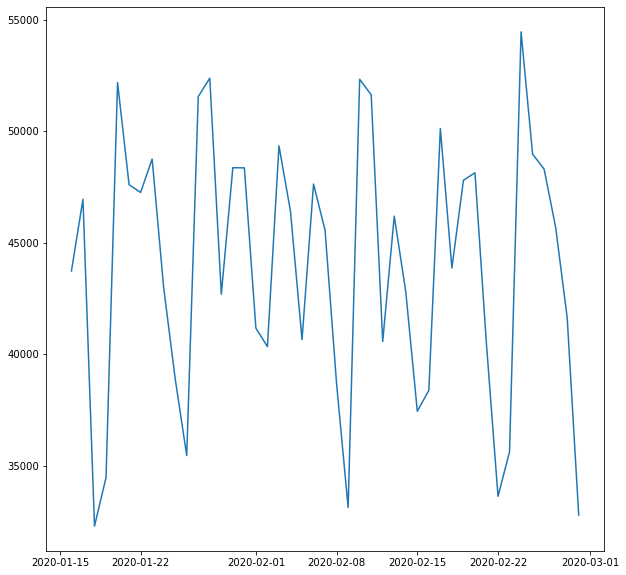

In [13]:
daily_first_pageviews = (first_pageviews. groupby('date_id')
                            .agg({'anonymous_id': 'count'})
                            .reset_index()
                            .rename(columns = {'anonymous_id' : 'visitors'}))


fig, ax = plt.subplots(figsize = (10, 10))

ax = plt.plot(daily_first_pageviews['date_id'], daily_first_pageviews['visitors'])

In [14]:
# check the assignment into the experiment. You should see that 7% of the visitors were 
# assigned to the experiment with a 50/50 split among the two variants

first_pageviews.fillna(0)['exp_id'].value_counts(normalize = True)*100  


#fill na's with 0 in specific column and count unique values, returning relative frequencies, thus *100

0.0      93.142992
101.0     3.432853
102.0     3.424155
Name: exp_id, dtype: float64

The assignment seemed to work as planned. You can now continue with the data prep.

## Create experiment dataset

To simplify the analysis, filter and merge the datasets to only focus on what's relevant. That is, you only care about visitors that were actually assigned to the experiment. Among those, you want to know how many subscribed. The proportion of those, for each group, is the conversion rate.

In [15]:
# merge the tables so you can see all visitors assigned to the experiment 
# and whether they subscribed or not
# create a dummy column for whether a user subscribed or not
first_pageviews_exp = first_pageviews.loc[ ~first_pageviews['exp_id'].isna()]
duo = pd.merge(first_pageviews_exp, users, on = 'anonymous_id', how = 'left')
combined = pd.merge(duo, subscriptions, on = 'user_id', how = 'left')
combined.head()

# 1. filter for all visitors that are in the experiment - that have an exp_id and assign to new df
# 2. left join (because we want to keep all visitors) with the users table and left join subscriptions

,date_id,anonymous_id,exp_id,user_id,created_at,client_app
0,2020-02-01,c8bc65ae-e5bb-47b0-b2ba-a3e32f086c39,101.0,NaN,NaT,NaN
1,2020-02-01,5808da06-67c6-467f-bedd-aa872839ccde,101.0,NaN,NaT,NaN
2,2020-02-01,3265ddda-fefc-471f-b956-fa88b1d85e08,101.0,NaN,NaT,NaN
3,2020-02-01,0b633f23-c070-4289-b323-058c0a4105fb,101.0,NaN,NaT,NaN
4,2020-02-01,72c9c459-ae27-407a-a257-901678774df2,101.0,NaN,NaT,NaN


In [16]:
combined = combined.assign(status_subscribed = (np.where(combined['user_id'].isna(), 0, 1)) )

In [17]:
combined.head()

,date_id,anonymous_id,exp_id,user_id,created_at,client_app,status_subscribed
0,2020-02-01,c8bc65ae-e5bb-47b0-b2ba-a3e32f086c39,101.0,NaN,NaT,NaN,0
1,2020-02-01,5808da06-67c6-467f-bedd-aa872839ccde,101.0,NaN,NaT,NaN,0
2,2020-02-01,3265ddda-fefc-471f-b956-fa88b1d85e08,101.0,NaN,NaT,NaN,0
3,2020-02-01,0b633f23-c070-4289-b323-058c0a4105fb,101.0,NaN,NaT,NaN,0
4,2020-02-01,72c9c459-ae27-407a-a257-901678774df2,101.0,NaN,NaT,NaN,0


## Inspect experiment data

Before running the test, you want to spend some time checking the data you collected.

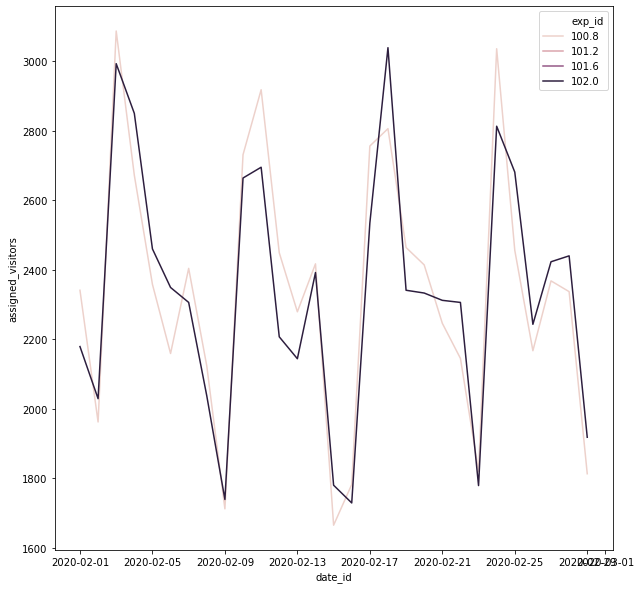

In [19]:
# plot a timeseries of daily visitors that were assigned to an experiment
# plot a line for each exp_id
daily_visitors = (combined.groupby(['date_id', 'exp_id'])
                  .agg({'anonymous_id':'count'})
                  .rename( columns = {'anonymous_id' :'assigned_visitors'})
                  .reset_index())


fig, ax = plt.subplots ( figsize = (10,10))

sns.lineplot(data = daily_visitors, x = 'date_id',
             y= 'assigned_visitors', hue = 'exp_id', ax = ax)


In [22]:
# does the time range match the experiment requirements?
# Do the lines indicate an equal assignment over time?
print(combined['date_id'].min())
print(combined['date_id'].max())

2020-02-01 00:00:00
2020-02-29 00:00:00


## Describing the data

Compute the differences among the groups, before running a statistical test

In [ ]:
# compute the number of conversion for each experiment group

In [ ]:
# compute the conversion rate for each experiment group

In [ ]:
# interpret the results. From just looking at the numbers, which group performed better 
# with respect to conversions or conversion rates?

You should see that there is a difference in the conversion rate across the different experiment groups.

Are there any differences among the subscibers for each group with respect to the client application they signed up through?

In [ ]:
# Compute relative frequency for each client_app through which they subscribed in each experiment group

In [ ]:
# interpret and discuss the results

## Test whether the difference in conversion rate is significant

It is time for the statistical test!

In [ ]:
# compute the two arrays/series to be passed to the t-test

In [ ]:
# run the test and compute the p-value, without the equal variance assumption

In [ ]:
# Write up your conclusion and discuss

The experiment unfortunately did not result in a significant difference among the two groups. That is, you cannot conclude that the upsells were in fact improving the conversion rates. You still doubt whether you've done everything in the right way. 

During a coffee break, you overheard some colleague talking about how they are contemplating about getting newspaper subscription. They said they have been going to the newspaper website a few times already but they're not sure if they're willing to pay the price. You start thinking that you were maybe a little to rushed with starting the analysis on the first day after the experiment ended. It might take some time for people to subscribe after the first pageview...

In [ ]:
# check the latest date a subscription was registered

In [ ]:
# Using the Five-number summary, check how long it takes for users to subscribe after their first visit

In [ ]:
# What is flawed when computing the five-number summary using this sample?

## Considering time it takes to subscribe

The team decides to wait for the analysis until the end of the month to allow users to subscribe. On April 1st, the Product Manager approaches you with even more excitement and pushes you to redo the analysis.

The data for the additional subscribers that signed up between the day of your first analysis and today can be found in `data/2020-04-01/`.

**Important:** The new data does not include any of the data that were included in the previous datasets.

In [ ]:
# load the newest data for subscriptions and their corresponding mapping in the users dataset

In [ ]:
# combine the newest data with the existing datasets

In [ ]:
# From here on, you're on your own. Redo the analysis from above with the new dataset.
# Make sure to run a few inspections to make sure your data is how you expect it to be
# After analyzing, provide a summary and a discussion including your communication to the Product Team